In [1]:
import openadmet_models
import json
import pandas as pd

In [2]:
path_to_data = "../../../CYP3A4_anvil_runs/"
folders = ['CYP3A4_cross_val', 'CYP3A4_descr_cross_val', 'CYP3A4_fp_cross_val']

df_combined = pd.read_json(f'{path_to_data}CYP3A4_cross_val/anvil_run/cross_validation_metrics.json')
df_combined['method'] = 'combined'

df_fp = pd.read_json(f'{path_to_data}CYP3A4_fp_cross_val/anvil_run/cross_validation_metrics.json')
df_fp['method'] = 'fingerprint'

df_descr = pd.read_json(f'{path_to_data}CYP3A4_descr_cross_val/anvil_run/cross_validation_metrics.json')
df_descr['method'] = 'descriptor'

dfs_all = pd.concat([df_combined, df_fp, df_descr])

metrics = ['mse', 'mae', 'r2', 'ktau', 'spearmanr']

dfs_all


,fit_time,score_time,mse,mae,r2,ktau,spearmanr,method
value,"[8.363051652908325, 8.358070850372314, 8.34479...","[0.007022619247436, 0.006872415542602, 0.00689...","[0.24799016371235302, 0.25457140427247504, 0.2...","[0.351902953100096, 0.360321865188574, 0.35778...","[0.44836298585821605, 0.44269081341290806, 0.4...","[0.43569857339740403, 0.42893376024379803, 0.4...","[0.5938092523575681, 0.586768310243939, 0.5923...",combined
mean,8.240763,0.00696,0.243859,0.353968,0.438767,0.427919,0.585584,combined
lower_ci,8.088575,0.006405,0.221208,0.342392,0.392981,0.402789,0.554131,combined
upper_ci,8.392952,0.007515,0.266511,0.365545,0.484552,0.453049,0.617037,combined
confidence_level,0.95,0.95,0.95,0.95,0.95,0.95,0.95,combined
value,"[0.673635721206665, 0.652476072311401, 0.65868...","[0.006034851074218001, 0.006004571914672001, 0...","[0.24857606142622501, 0.25596997611703504, 0.2...","[0.361403437152476, 0.362273105177354, 0.36228...","[0.44705969680580004, 0.43962905186391205, 0.4...","[0.40554759653126105, 0.41113342527883, 0.4161...","[0.558356543135876, 0.5671109042704661, 0.5735...",fingerprint
mean,0.675274,0.00612,0.247713,0.361972,0.429747,0.402729,0.555669,fingerprint
lower_ci,0.633592,0.005506,0.227272,0.35047,0.382191,0.379026,0.524464,fingerprint
upper_ci,0.716955,0.006734,0.268154,0.373474,0.477303,0.426431,0.586873,fingerprint
confidence_level,0.95,0.95,0.95,0.95,0.95,0.95,0.95,fingerprint


In [3]:
### LEVENE TEST ###
from scipy.stats import levene
for m in metrics:
    print(f'{m}: ' + str(levene(df_combined[m].value, df_fp[m].value, df_descr[m].value)))

mse: LeveneResult(statistic=0.2963738998768453, pvalue=0.7444120332219919)
mae: LeveneResult(statistic=0.3913559828714932, pvalue=0.6775688826791365)
r2: LeveneResult(statistic=0.3381967830040038, pvalue=0.7141815393578078)
ktau: LeveneResult(statistic=0.05033310952264555, pvalue=0.9509460423298629)
spearmanr: LeveneResult(statistic=0.23161805161450738, pvalue=0.7938377878544016)


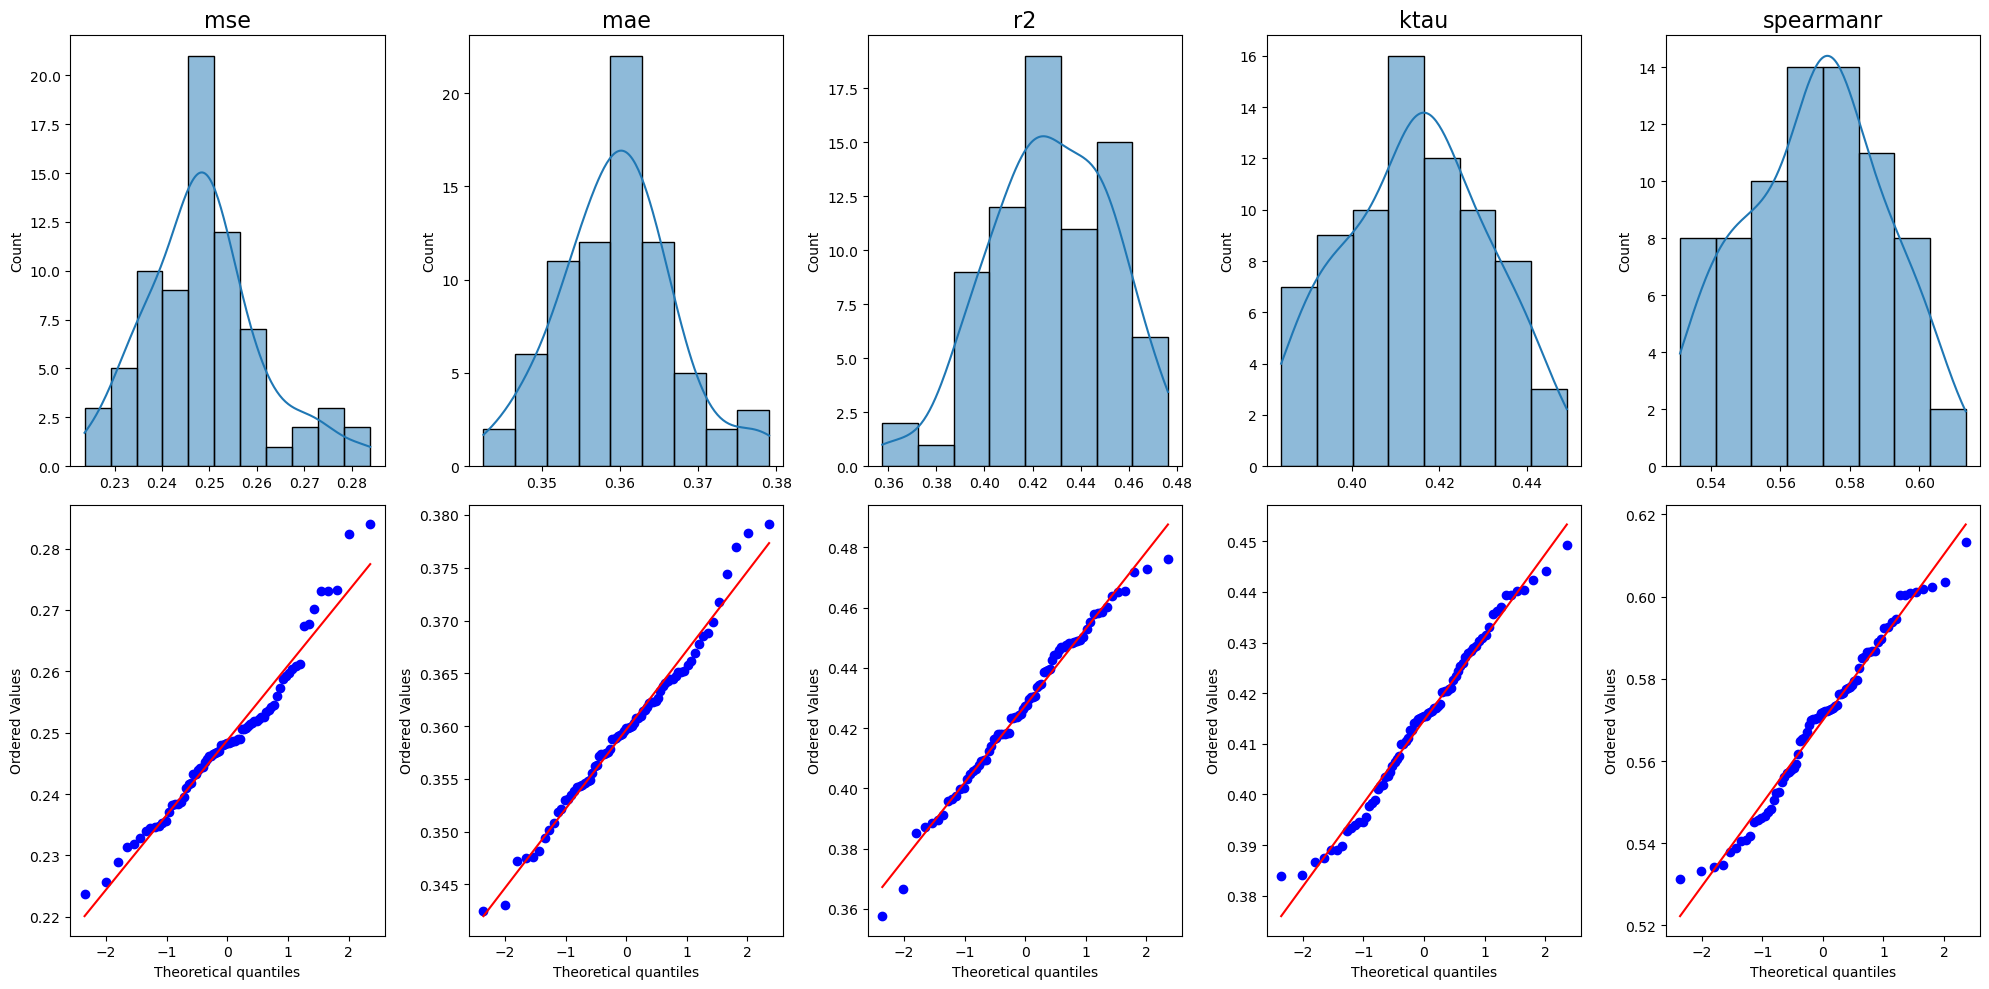

In [4]:
### NORMALITY TEST ###
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools

fig, axes = plt.subplots(2, len(metrics), figsize=(20, 10))

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    vals = []
    for i in dfs_all[metric].value:
        for n in i:
            vals.append(n)
    sns.histplot(vals, kde=True, ax=ax)
    ax.set_title(f'{metric}', fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[1, i]
    vals = []
    for i in dfs_all[metric].value:
        for n in i:
            vals.append(n)
    stats.probplot(vals, dist="norm", plot=ax)
    ax.set_title("")

plt.tight_layout()


         mse       mae        r2      ktau  spearmanr      method
0   0.247990  0.351903  0.448363  0.435699   0.593809    combined
1   0.254571  0.360322  0.442691  0.428934   0.586768    combined
2   0.231848  0.357785  0.471974  0.430258   0.592336    combined
3   0.252503  0.354922  0.423656  0.425870   0.579509    combined
4   0.225729  0.342488  0.423501  0.417890   0.571643    combined
..       ...       ...       ...       ...        ...         ...
20  0.260372  0.363804  0.418282  0.425423   0.585225  descriptor
21  0.240995  0.358744  0.388606  0.383800   0.534714  descriptor
22  0.282320  0.378243  0.366552  0.394577   0.546179  descriptor
23  0.251044  0.363333  0.426408  0.415364   0.572976  descriptor
24  0.245773  0.354821  0.452782  0.439430   0.601002  descriptor

[75 rows x 6 columns]


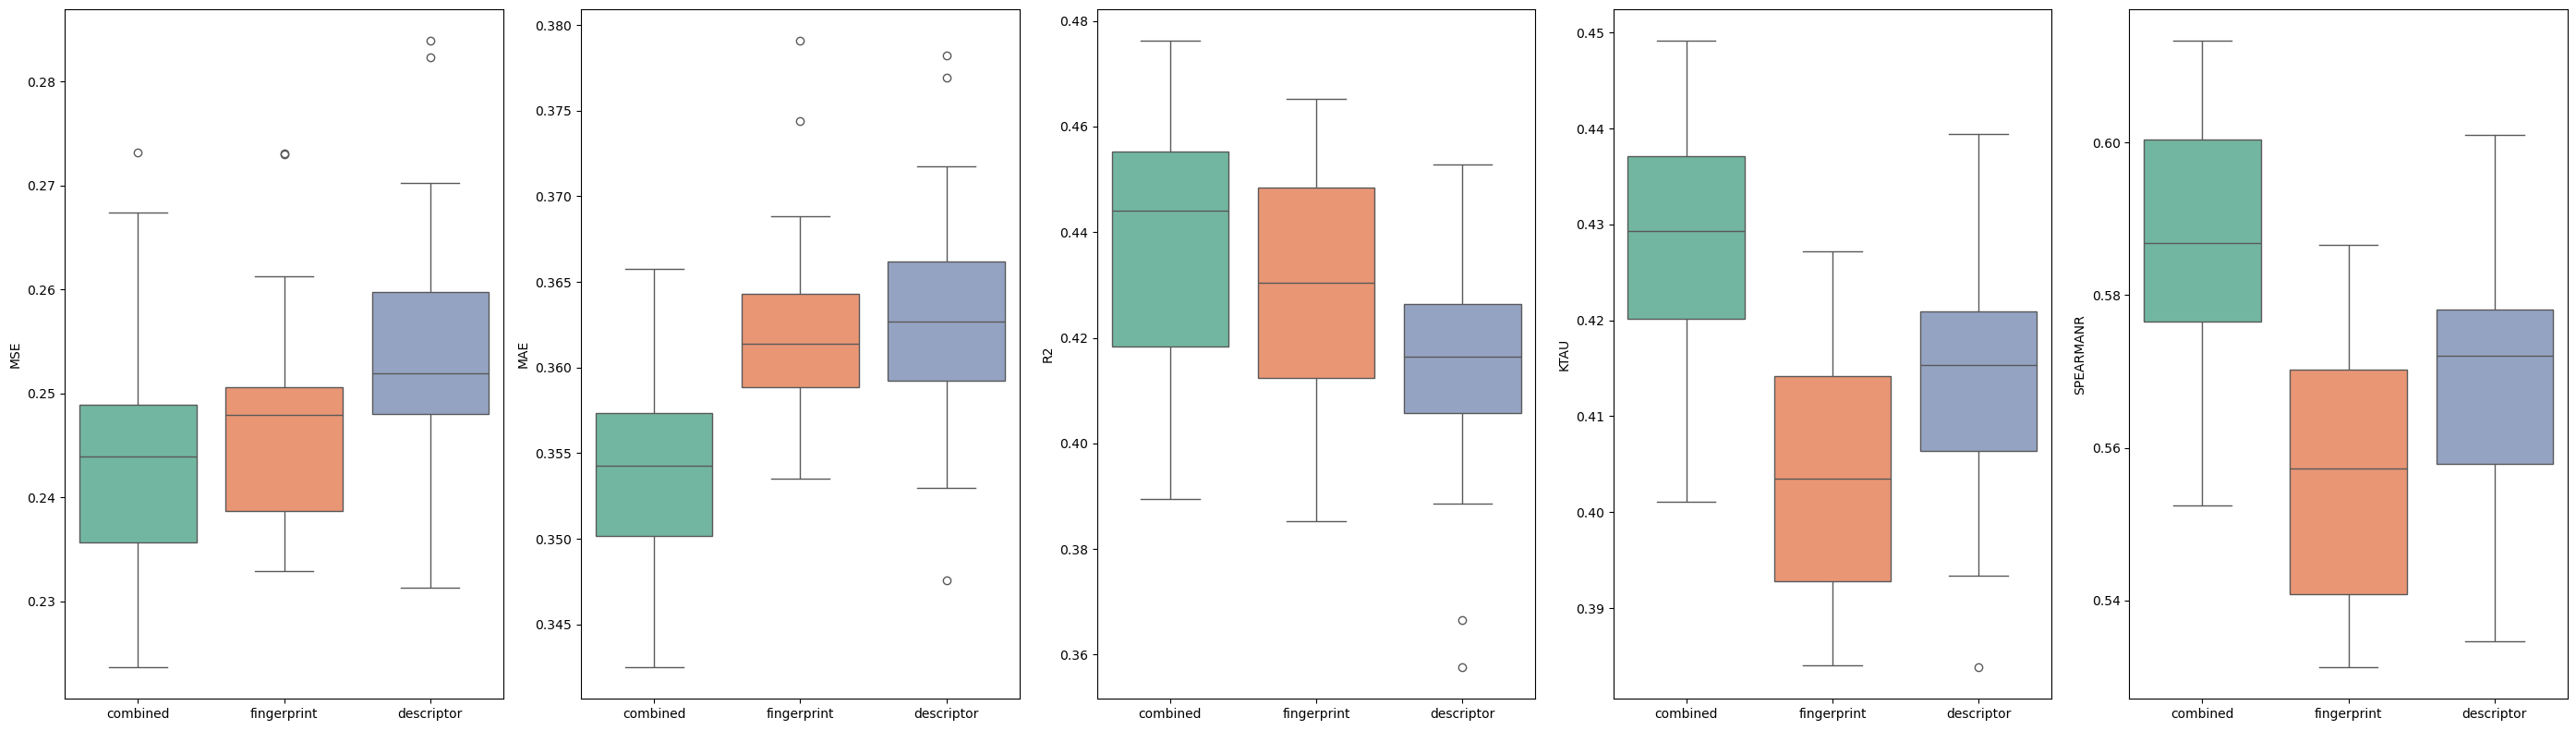

In [5]:
### ANOVA ###
from scipy.stats import f_oneway
methods = ['combined', 'fingerprint', 'descriptor']
data = pd.DataFrame()
for method in methods:
    method_data = pd.DataFrame()
    for stat in metrics:
        values = dfs_all.loc[dfs_all['method'] == method, stat].value
        method_data[stat] = values
    method_data['method'] = method
    data = pd.concat([data, method_data])
print(data)
figure, axes = plt.subplots(1, len(metrics), sharex=False, sharey=False, figsize=(28, 8))
for i, stat in enumerate(metrics):
    model = f_oneway(df_combined[stat].value, df_fp[stat].value, df_descr[stat].value)
    # p_value = model.anova_table['Pr > F'].iloc[0]
    ax = sns.boxplot(y=stat, x='method', hue='method', ax=axes[i], data=data, palette="Set2", legend=False)
    title = stat.upper()
    # ax.set_title(f"p={p_value:.1e}")
    ax.set_xlabel("")
    ax.set_ylabel(title)
    x_tick_labels = ax.get_xticklabels()
    label_text_list = [x.get_text() for x in x_tick_labels]
    new_xtick_labels = ["\n".join(x.split("_")) for x in label_text_list]
    ax.set_xticks(list(range(0, len(x_tick_labels))))
    ax.set_xticklabels(new_xtick_labels)
plt.tight_layout()

In [6]:
import warnings
from statsmodels.stats.libqsturng import psturng, qsturng
import numpy as np

def rm_tukey_hsd(df, metric, alpha=0.05, sort = False, direction_dict=None):
    """
    Perform repeated measures Tukey HSD test on the given dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe containing the data.
    metric (str): The metric column name to perform the test on.
    group_col (str): The column name indicating the groups.
    alpha (float): Significance level for the test. Default is 0.05.
    sort (bool): Whether to sort the output tables. Default is False.

    Returns:
    tuple: A tuple containing:
        - result_tab (pd.DataFrame): DataFrame with pairwise comparisons and adjusted p-values.
        - df_means (pd.DataFrame): DataFrame with mean values for each group.
        - df_means_diff (pd.DataFrame): DataFrame with mean differences between groups.
        - pc (pd.DataFrame): DataFrame with adjusted p-values for pairwise comparisons.
    """
    if sort and direction_dict and metric in direction_dict:
        if direction_dict[metric] == 'maximize':
            df_means = df.groupby('method').mean(numeric_only=True).sort_values(metric, ascending=False)
        elif direction_dict[metric] == 'minimize':
            df_means = df.groupby('method').mean(numeric_only=True).sort_values(metric, ascending=True)
        else:
            raise ValueError("Invalid direction. Expected 'maximize' or 'minimize'.")
    else:
        df_means = df.groupby('method').mean(numeric_only=True)

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning,
                                message='divide by zero encountered in scalar divide')
        aov = f_oneway(df_combined[stat].value, df_fp[stat].value, df_descr[stat].value)
    mse = aov.loc[1, 'MS']
    df_resid = aov.loc[1, 'DF']

    methods = df_means.index
    n_groups = len(methods)
    n_per_group = 25

    tukey_se = np.sqrt(2 * mse / (n_per_group))
    q = qsturng(1 - alpha, n_groups, df_resid)

    num_comparisons = len(methods) * (len(methods) - 1) // 2
    result_tab = pd.DataFrame(index=range(num_comparisons),
                              columns=["group1", "group2", "meandiff", "lower", "upper", "p-adj"])

    df_means_diff = pd.DataFrame(index=methods, columns=methods, data=0.0)
    pc = pd.DataFrame(index=methods, columns=methods, data=1.0)

    # Calculate pairwise mean differences and adjusted p-values
    row_idx = 0
    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i < j:
                group1 = df[df['method'] == method1][metric]
                group2 = df[df['method'] == method2][metric]
                mean_diff = group1.mean() - group2.mean()
                studentized_range = np.abs(mean_diff) / tukey_se
                adjusted_p = psturng(studentized_range * np.sqrt(2), n_groups, df_resid)
                if isinstance(adjusted_p, np.ndarray):
                    adjusted_p = adjusted_p[0]
                lower = mean_diff - (q / np.sqrt(2) * tukey_se)
                upper = mean_diff + (q / np.sqrt(2) * tukey_se)
                result_tab.loc[row_idx] = [method1, method2, mean_diff, lower, upper, adjusted_p]
                pc.loc[method1, method2] = adjusted_p
                pc.loc[method2, method1] = adjusted_p
                df_means_diff.loc[method1, method2] = mean_diff
                df_means_diff.loc[method2, method1] = -mean_diff
                row_idx += 1

    df_means_diff = df_means_diff.astype(float)

    result_tab["group1_mean"] = result_tab["group1"].map(df_means[metric])
    result_tab["group2_mean"] = result_tab["group2"].map(df_means[metric])

    result_tab.index = result_tab['group1'] + ' - ' + result_tab['group2']

    return result_tab, df_means, df_means_diff, pc

/var/folders/4h/4_v2nd3n4dn85gnfv734rbbc0000gn/T/ipykernel_37246/2814663967.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  significance[(hsd.pvalue < 0.01) & (hsd.pvalue >= 0.001)] = '**'
/var/folders/4h/4_v2nd3n4dn85gnfv734rbbc0000gn/T/ipykernel_37246/2814663967.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  significance[(hsd.pvalue >= 0.05)] = ''
/var/folders/4h/4_v2nd3n4dn85gnfv734rbbc0000gn/T/ipykernel_37246/2814663967.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '***' has dtype incompatible with float64, please explicitly cast to a c

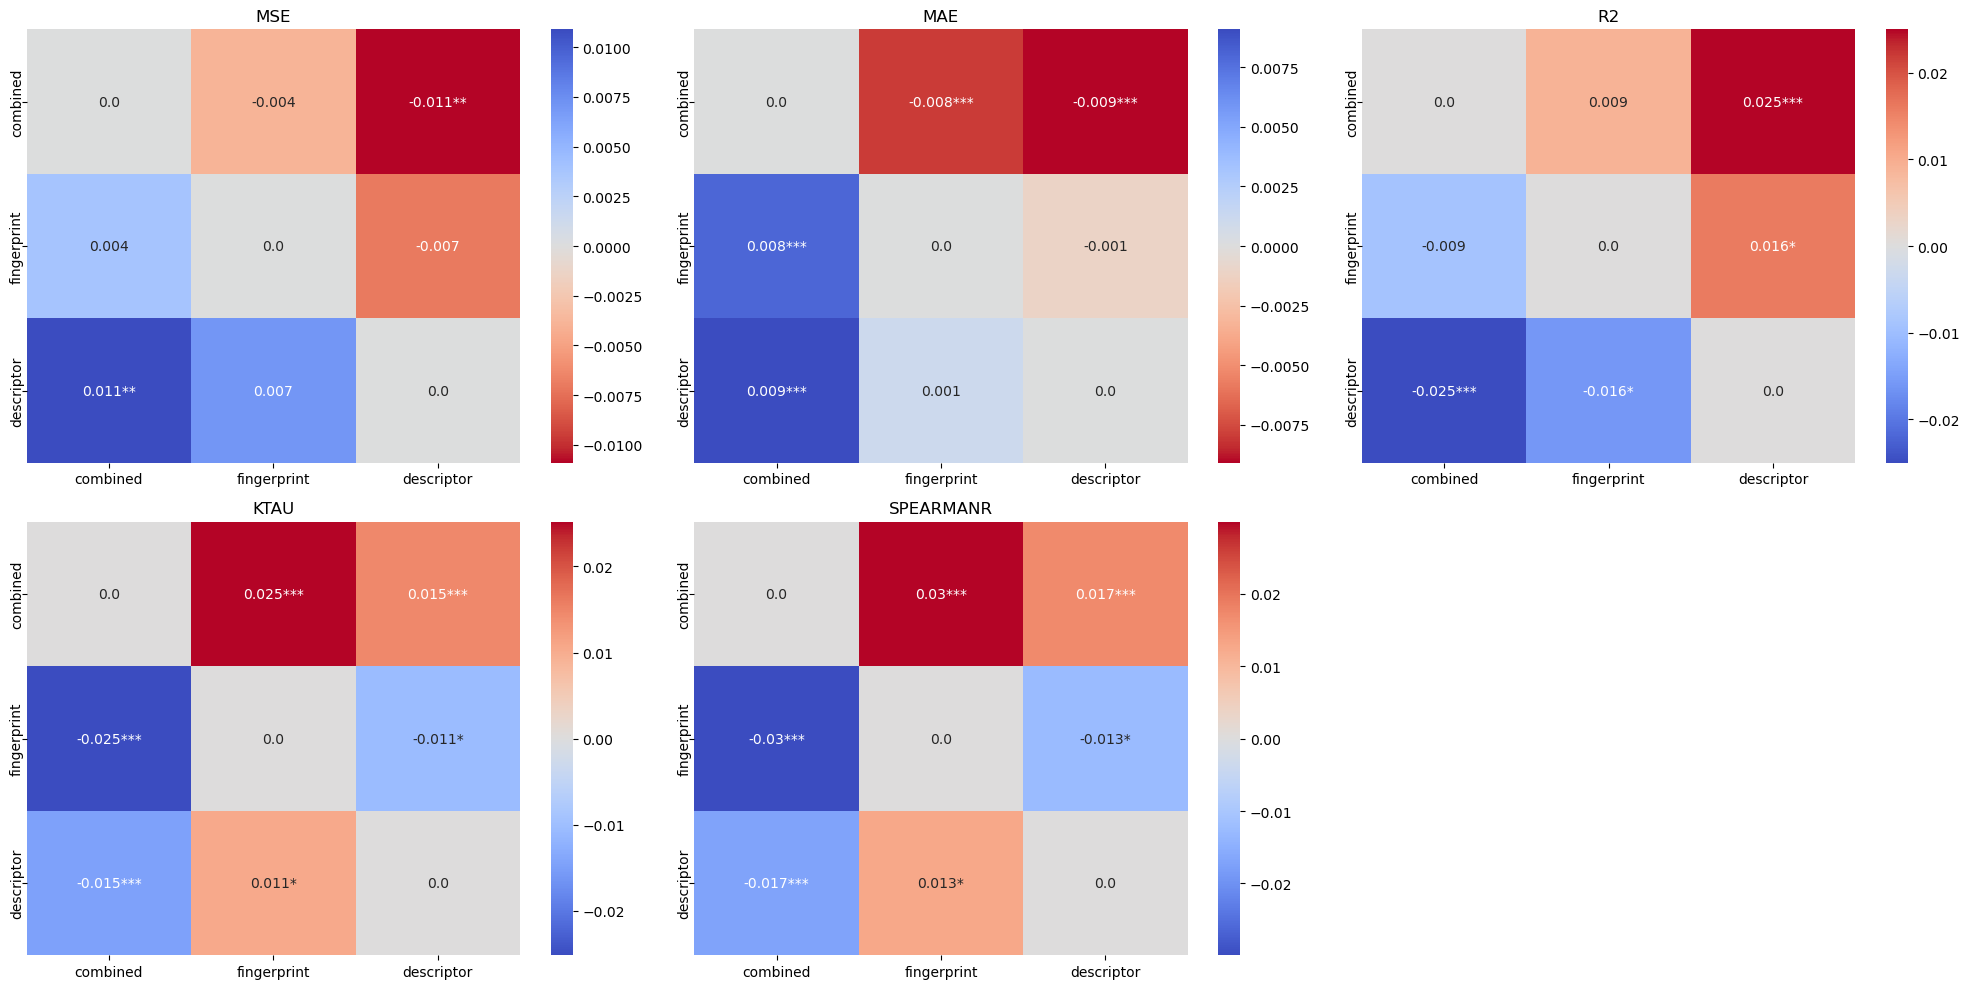

In [10]:
import math
from polaris_model_comparison import mcs_plot
from scipy.stats import tukey_hsd

figsize = (20,10)
nrow = math.ceil(len(metrics) / 3)
fig, ax = plt.subplots(nrow, 3, figsize=figsize)

# do we want to norm to between 0 and 1 for spearmanr?
direction_dict = {'mae':'minimize', 'mse':'minimize', 'r2':'maximize', 'ktau':'maximize', 'spearmanr':'maximize'}
effect_dict = {'mae': .2, 'mse': .2, 'r2':.2, 'ktau':.2, 'spearmanr':.2}
effect_size = pd.DataFrame([effect_dict])
alpha = 0.05

for i, stat in enumerate(metrics):
    stat = stat.lower()

    row = i // 3
    col = i % 3

    reverse_cmap = False
    if direction_dict[stat] == 'minimize':
        reverse_cmap = True

    
    hsd = tukey_hsd(data[data['method']=='combined'][stat], data[data['method']=='fingerprint'][stat], data[data['method']=='descriptor'][stat])

    cmap = "coolwarm"
    if reverse_cmap:
        cmap = cmap + "_r"

    significance = pd.DataFrame(hsd.pvalue)
    significance[(hsd.pvalue < 0.001) & (hsd.pvalue >= 0)] = '***'
    significance[(hsd.pvalue < 0.01) & (hsd.pvalue >= 0.001)] = '**'
    significance[(hsd.pvalue < 0.05) & (hsd.pvalue >= 0.01)] = '*'
    significance[(hsd.pvalue >= 0.05)] = ''

    # Create a DataFrame for the annotations
    annotations = pd.DataFrame(hsd.statistic).round(3).astype(str) + significance

    hax = sns.heatmap(pd.DataFrame(hsd.statistic), cmap=cmap, annot=annotations, fmt='', ax=ax[row,col],
                      vmin=None, vmax=None)

    label_list = list(['combined', 'fingerprint', 'descriptor'])
    x_label_list = [x for x in label_list]
    y_label_list = [x for x in label_list]
    hax.set_xticklabels(x_label_list, ha='center', va='top', rotation=0,
                        rotation_mode='anchor')
    hax.set_yticklabels(y_label_list, ha='center', va='center', rotation=90,
                        rotation_mode='anchor')

    hax.set_xlabel('')
    hax.set_ylabel('')
    hax.set_title(stat.upper())

# If there are less plots than cells in the grid, hide the remaining cells
if (len(metrics) % 3) != 0:
    for i in range(len(metrics), nrow * 3):
        row = i // 3
        col = i % 3
        ax[row, col].set_visible(False)

plt.tight_layout()

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.004     0.462    -0.012     0.004
 (0 - 2)     -0.011     0.003    -0.019    -0.003
 (1 - 0)      0.004     0.462    -0.004     0.012
 (1 - 2)     -0.007     0.082    -0.015     0.001
 (2 - 0)      0.011     0.003     0.003     0.019
 (2 - 1)      0.007     0.082    -0.001     0.015

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.008     0.000    -0.012    -0.004
 (0 - 2)     -0.009     0.000    -0.013    -0.005
 (1 - 0)      0.008     0.000     0.004     0.012
 (1 - 2)     -0.001     0.815    -0.005     0.003
 (2 - 0)      0.009     0.000     0.005     0.013
 (2 - 1)      0.001     0.815    -0.003     0.005

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.009     0.362    -0.007     

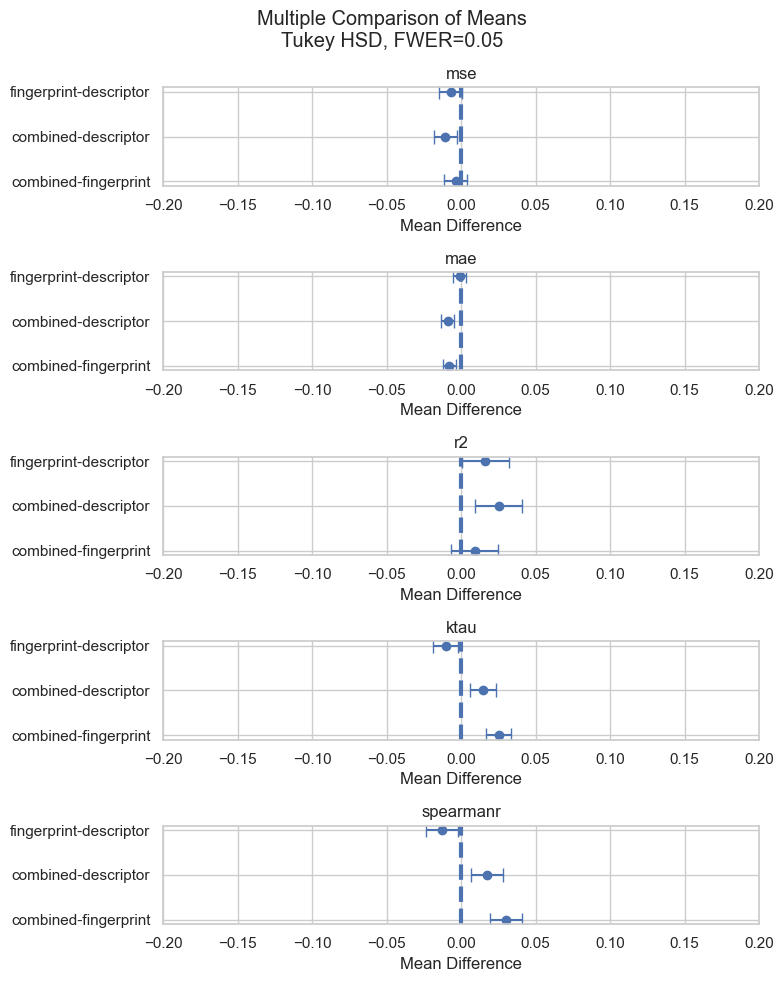

In [97]:
from polaris_model_comparison import ci_plot

metric_list = ['mse', 'mae', 'r2', 'ktau', 'spearmanr']
method_list = ['combined', 'fingerprint', 'descriptor']
figure, axes = plt.subplots(len(metric_list), 1, figsize=(8, 2 * len(metric_list)), sharex=False)
ax_ind = 0
for metric in metric_list:
    hsd = tukey_hsd(data[data['method']=='combined'][metric], data[data['method']=='fingerprint'][metric], data[data['method']=='descriptor'][metric])
    print(hsd)
    hsd_df = pd.DataFrame()
    method_compare = []
    stats = []
    errorbars = []
    stat_ind = 0
    for i in range(len(hsd.statistic)-1):
        for j in range(i+1, len(row)):
            stat = hsd.statistic[i,j]
            method_compare.append(f'{method_list[i]}-{method_list[j]}')
            stats.append(stat)
            errorbars.append([stat-hsd.confidence_interval(confidence_level=0.95).low[i,j],
                             hsd.confidence_interval(confidence_level=0.95).high[i,j]-stat])
            stat_ind += 1
    errorbars = np.transpose(errorbars)
    hsd_df = pd.DataFrame({"method":method_compare,"stat":stats})
    sns.set(rc={'figure.figsize': (6, 2)})
    sns.set_context('notebook')
    sns.set_style('whitegrid')
    ax = axes[ax_ind]
    ax.errorbar(data=hsd_df, x="stat", y="method", xerr=errorbars, fmt='o', capsize=5)
    ax.axvline(0, ls="--", lw=3)
    ax.set_title(metric)
    ax.set_xlabel("Mean Difference")
    ax.set_ylabel("")
    ax.set_xlim(-0.2, 0.2) 
    ax_ind += 1
figure.suptitle("Multiple Comparison of Means\nTukey HSD, FWER=0.05")
plt.tight_layout()